In [28]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from sklearn import mixture

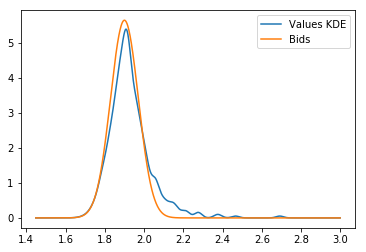

In [29]:
#draw data
n=2000

bids = np.concatenate((np.random.normal(loc=1.7, scale=0.06, size=int(.8*n)), 
                      np.random.normal(loc=1.9, scale=0.07, size=int(.2*n))))

#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(bids.reshape(n,1))
ind =  np.argmax(g.means_, axis=0)[0]

#print values given competitive distribution
i = 7.
g1 = lambda b: scipy.stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
G1 = lambda b: scipy.stats.norm.cdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
values = bids + 1/(i-1)*G1(bids)/g1(bids)

#KDE_weighted
q = g.predict_proba(bids.reshape(n,1))[:,ind]
kde = sm.nonparametric.KDEUnivariate(values)

kde.fit(weights=q, fft=False)
plt.plot(kde.support[kde.support<=3], kde.density[kde.support<=3], label='Values KDE')
plt.plot(kde.support[kde.support<=3], g1(kde.support[kde.support<=3]), label='Bids')

plt.legend()
plt.show()

In [30]:
def interp_cdf(x,kde):
    """apparantly this isn't in statsmodels, want to make sure this is smooth"""
    #make sure this is safe
    if kde.support.min() >= x:
        return np.array([0])
    if kde.support.max() <= x:
        return np.array([1])
        
    x_left = kde.support[kde.support < x][-1]
    x_right = kde.support[kde.support > x][0]
    
    cdf_left = kde.cdf[kde.support < x][-1]
    cdf_right = kde.cdf[kde.support > x][0]
    
    return cdf_left + (x-x_left)*(cdf_right-cdf_left)/(x_right-x_left)
 
print interp_cdf(7,kde)

[1]


[1.9265921] [1.91041275]


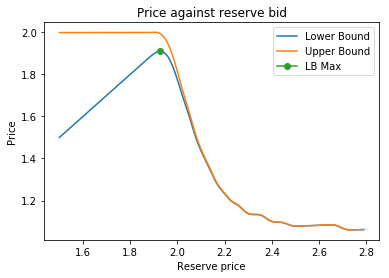

In [39]:
def pi_l(p, vs, i, kde):
    """lower bound for profit"""
    pi = []
    for q in p:
        q_cdf = interp_cdf(np.array([q]),kde)
        pi_q = vs*q_cdf**(i) + q*(1-q_cdf**i)
        pi = np.concatenate((pi,pi_q))   
    return pi
    
    
def pi_u(p, vs, i, kde):
    """upper bound for profit"""
    integrand = i*(i-1)*(1-kde.cdf)*kde.support*kde.cdf**(i-2)*kde.density
    integrand = scipy.interpolate.BSpline(kde.support, integrand, 1)
    pi = []
    for q in p:
        q_cdf = interp_cdf(np.array([q]),kde)
        baseline = vs*q_cdf**i + i*q*(1-q_cdf)*q_cdf**(i-1)
        integral = integrand.integrate(q, kde.support.max())
        pi = np.concatenate((pi, baseline+ integral))    
    return pi


def pi_opt(vs, i, kde):
    """argmax of lower bound"""
    obj = lambda p: -1*pi_l(p, vs, i, kde)
    result = scipy.optimize.differential_evolution(obj, [(kde.support.min(),kde.support.max())])
    return result.x, -1*obj(result.x)

vs= 1.
support = np.arange(1.5,2.8,.01)

lb = pi_l(support, vs, i, kde)
plt.plot(support, lb, label='Lower Bound')

ub = pi_u(support, vs, i, kde)
plt.plot(support, ub, label='Upper Bound')

argmax_lb, max_lb  = pi_opt(vs, i, kde)
print argmax_lb, max_lb
plt.plot(argmax_lb, max_lb, label='LB Max',marker='o')


plt.xlabel('Reserve price')
plt.ylabel('Price')
plt.title('Price against reserve bid')
plt.legend()
plt.show()

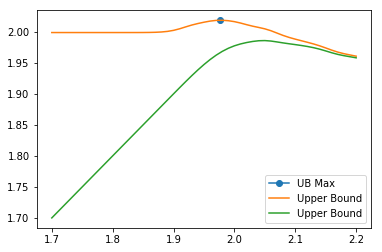

In [40]:
support2 = np.arange(1.7,2.2,.01)

def pi_opt_ub(vs, i, kde):
    """argmax of upper bound"""
    obj = lambda p: -1*pi_u(p, vs, i, kde)
    result = scipy.optimize.differential_evolution(obj,
                                                   [(kde.support.min(),kde.support.max())])
    return result.x, -1*obj(result.x)


argmax_ub, max_ub  = pi_opt_ub(1.9, i, kde)
plt.plot(argmax_ub, max_ub, label='UB Max',marker='o')

ub2 = pi_u(support2, 1.9, i, kde)
plt.plot(support2, ub2, label='Upper Bound')

lb2 = pi_l(support2, 1.9, i, kde)
plt.plot(support2, lb2, label='Upper Bound')


plt.legend()
plt.show()

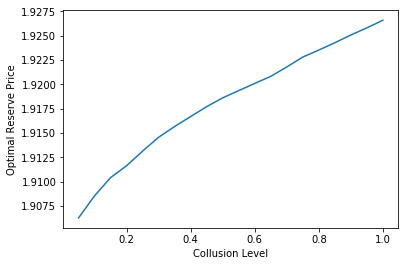

In [41]:
def pi_helper(q, vs, i, kde):
    """argmax of lower bound"""
    obj = lambda p: -q*pi_l(p, vs, i, kde) - (1-q)*pi_u(p, vs, i, kde)
    result = scipy.optimize.differential_evolution(obj, 
                                                   [(kde.support.min(),kde.support.max())])
    return result.x, -1*obj(result.x)

qs = np.arange(0.05,1.05,.05)
ps = [] 
for q in qs:
    pq = pi_helper(q, vs, i, kde)
    ps.append(pq[0][0])
ps = np.array(ps)


plt.plot(qs,ps)
plt.xlabel('Collusion Level')
plt.ylabel('Optimal Reserve Price')
plt.show()

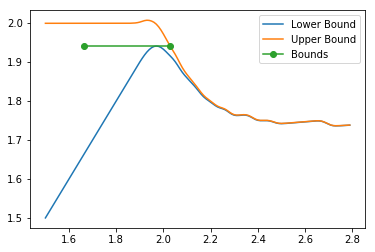

In [47]:
def pi_est(vs, i, kde):
    """calculate the """
    argmax, maxim = pi_opt( vs, i, kde)
   
    obj = lambda p: (pi_u(p, vs, i, kde) - maxim)**2
    
    #left bound
    bnds1 = [(kde.support.min(),argmax)]
    result1 = scipy.optimize.differential_evolution(obj, bnds1)
    
    #right bound
    bnds2 = [(argmax,kde.support.max())]
    result2 = scipy.optimize.differential_evolution(obj, bnds2)
    
    return np.array([result1.x,result2.x])


vs= 1.7
support = np.arange(1.5,2.8,.01)

lb = pi_l(support, vs, i, kde)
plt.plot(support, lb, label='Lower Bound')

ub = pi_u(support, vs, i, kde)
plt.plot(support, ub, label='Upper Bound')

argmax_lb, max_lb  = pi_opt(vs, i, kde)

#calculate bounds
p_bnds = pi_est(vs, i, kde)
plt.plot(p_bnds, np.tile(max_lb,2), label='Bounds',marker='o')
plt.legend()
plt.show()

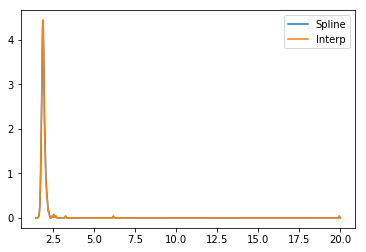

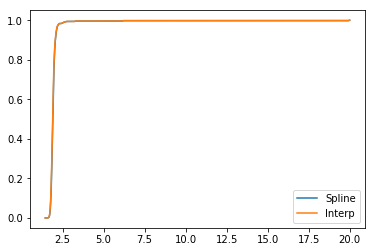

In [40]:
#spline vs interpolation
spline_pdf = scipy.interpolate.BSpline(kde.support, kde.density, 1)
interp_pdf = scipy.interpolate.interp1d(kde.support,  kde.density, fill_value="extrapolate")

plt.plot(kde.support, spline_pdf(kde.support), label='Spline')
plt.plot(kde.support, interp_pdf(kde.support), label='Interp')
plt.legend()
plt.show()

#check cdf
spline_cdf = scipy.interpolate.BSpline(kde.support, kde.cdf, 1)
interp_cdf = scipy.interpolate.interp1d(kde.support,  kde.cdf, fill_value="extrapolate")

plt.plot(kde.support, spline_cdf(kde.support), label='Spline')
plt.plot(kde.support, interp_cdf(kde.support), label='Interp')
plt.legend()
plt.show()